# Training a network: Flax vs PyTorch

In [1]:
import flax.linen as jnn
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import numpy as np
import optax
import torch
import torch.nn as nn
import torch.optim as optim
from flax.training import train_state
from jax.flatten_util import ravel_pytree
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

from pbnn.utils.data import NumpyDataset, NumpyLoader

%load_ext watermark

## Generate data

In [2]:
def test_function(x):
    return np.sin(2.0 * x) + np.cos(x)


n = 100
noise_level = 0.1

np.random.seed(0)
X = 20 * np.random.rand(n, 1)
X_test = np.linspace(0, 20, 200)[:, None]

noise, noise_test = (
    np.random.randn(n, 1) * noise_level,
    np.random.randn(len(X_test), 1) * noise_level,
)

y = test_function(X) + noise
y_test = test_function(X_test) + noise_test

scaler = StandardScaler()
X_ = scaler.fit_transform(X)
X_test_ = scaler.transform(X_test)

## Set some hyperparameters

In [3]:
num_epochs = 1000
step_size = 5e-3
batch_size = 32

## Training with Flax

### Define network

In [4]:
class MLP(jnn.Module):
    """Simple MLP."""

    @jnn.compact
    def __call__(self, x):
        x = jnn.Dense(features=50)(x)
        x = jnn.tanh(x)
        x = jnn.Dense(features=50)(x)
        x = jnn.tanh(x)
        x = jnn.Dense(features=1)(x)
        return x


network = MLP()

### Define loss function

In [5]:
def loss_fn(params, batch):
    X, y = batch
    pred = network.apply({"params": params}, X)
    return jnp.mean(optax.l2_loss(y, pred))

### Training pipeline

In [6]:
@jax.jit
def train_step(state, batch):
    grad_fn = jax.grad(loss_fn)
    grads = grad_fn(state.params, batch)
    state = state.apply_gradients(grads=grads)
    return state


rng_key = jr.PRNGKey(0)
rng_key, init_rng = jr.split(rng_key)

init_params = network.init(init_rng, X_)["params"]
tx = optax.adam(step_size)
state = train_state.TrainState.create(apply_fn=network.apply, params=init_params, tx=tx)

dataset = NumpyDataset(X_, y)
data_loader = NumpyLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

for epoch in range(num_epochs):
    for batch in data_loader:
        state = train_step(state, batch)

pred_flax = network.apply({"params": state.params}, X_test_)

## Training with PyTorch

### Get initial parameters

Using the same initial state as the flax model

In [7]:
parameters, _ = ravel_pytree(init_params)
parameters = torch.tensor(np.array(parameters), dtype=torch.float32)

model = nn.Sequential(
    nn.Linear(1, 50), nn.Tanh(), nn.Linear(50, 50), nn.Tanh(), nn.Linear(50, 1)
)

with torch.no_grad():
    pointer = 0
    for param in parameters:
        num_param = param.numel()
        param.copy_(parameters[pointer : pointer + num_param].view(param.size()))
        pointer += num_param

### Training pipeline

In [8]:
mse_fn = nn.MSELoss()

train_loader = DataLoader(
    dataset=TensorDataset(
        torch.tensor(X_, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
    ),
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
)

optimizer = optim.Adam(model.parameters(), lr=step_size)
for epoch in range(num_epochs):
    for ib, (x_batch, y_batch) in enumerate(train_loader):
        optimizer.zero_grad()
        pred = model(x_batch)
        loss = mse_fn(y_batch, pred)
        loss.backward()
        optimizer.step()

with torch.no_grad():
    pred_torch = (
        model(torch.tensor(X_test_, dtype=torch.float32)).detach().cpu().numpy()
    )

## Compare predictions

Text(0, 0.5, '$y$')

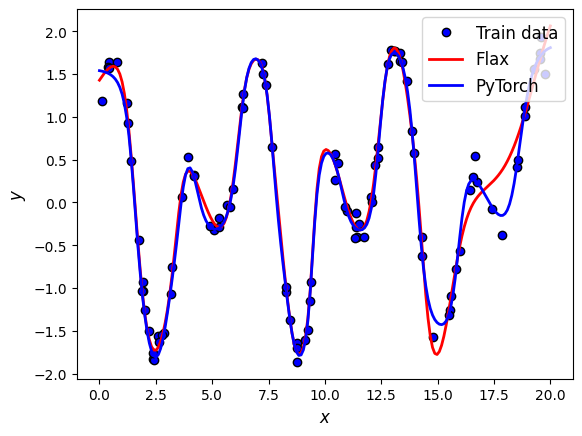

In [9]:
plt.figure()
plt.plot(
    X,
    y,
    ls="",
    marker="o",
    markerfacecolor="b",
    markeredgecolor="k",
    markeredgewidth=1,
    label="Train data",
)
plt.plot(X_test, pred_flax, color="r", lw=2, label="Flax")
plt.plot(X_test, pred_torch, color="b", lw=2, label="PyTorch")
plt.legend(fontsize=12)
plt.xlabel(r"$x$", fontsize=12)
plt.ylabel(r"$y$", fontsize=12)

In [10]:
%reload_ext watermark
%watermark -n -u -v -iv -w -a 'Brian Staber'

Author: Brian Staber

Last updated: Sun Aug 31 2025

Python implementation: CPython
Python version       : 3.12.9
IPython version      : 9.0.2

sklearn   : 1.6.1
jax       : 0.5.3
pbnn      : 0.1.0
torch     : 2.6.0
numpy     : 2.2.4
matplotlib: 3.10.1
optax     : 0.2.4
flax      : 0.10.4

Watermark: 2.5.0

